# Estimating COVID-19's $R_t$ in Real-Time
Kevin Systrom - April 12

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation.

The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't use $R_t$ in this way. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) level granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While this paper estimates a static $R$ value, here we introduce a Gaussian process model to estimate a time-varying $R_t$

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

Huge thanks to [Frank Dallaert](http://www.twitter.com/fdellaert/) who suggested the addition of the Gaussian process and to [Adam Lerer](http://www.twitter.com/adamlerer/) who implemented the changes.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(R_t)\cdot\mathcal{L}(k|R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- times the __likelihood__ of seeing $k$ new cases given $R_t$ ...
- divided by the probability of seeing this many cases in general.

Importantly, $P(k)$ is a constant, so the numerator is proportional to the posterior. Since all probability distributions sum to 1.0, we can ignore $P(k)$ and normalize our posterior to sum to 1.0:

$$ P(R_t|k) \propto P(R_t) \cdot \mathcal{L}(k|R_t) $$

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. 

We will assume an uncorrelated Gaussian process, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:\n

$$ P(R_1|k) \propto P(R_0)\cdot \mathcal{L}(k_1|R_1)$$

On day two:

$$ P(R_2|k) \propto P(R_0)\cdot\mathcal{L}(k_2|R_2)\cdot\mathcal{L}(k_1|R_1) $$

etc.

### Choosing a Likelihood Function $\mathcal{L}\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Note__: this was a terse expression which makes it tricky. All I did was to make $k$ a column. By giving it a column for $k$ and a 'row' for lambda it will evaluate the pmf over both and produce an array that has $k$ rows and lambda columns. This is an efficient way of producing many distributions all at once, and __you will see it used again below__!

/home/alex/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


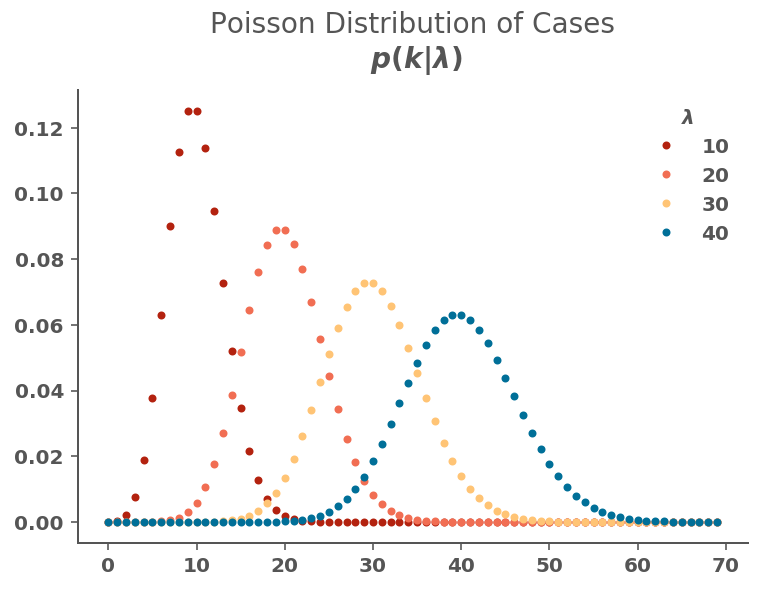

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

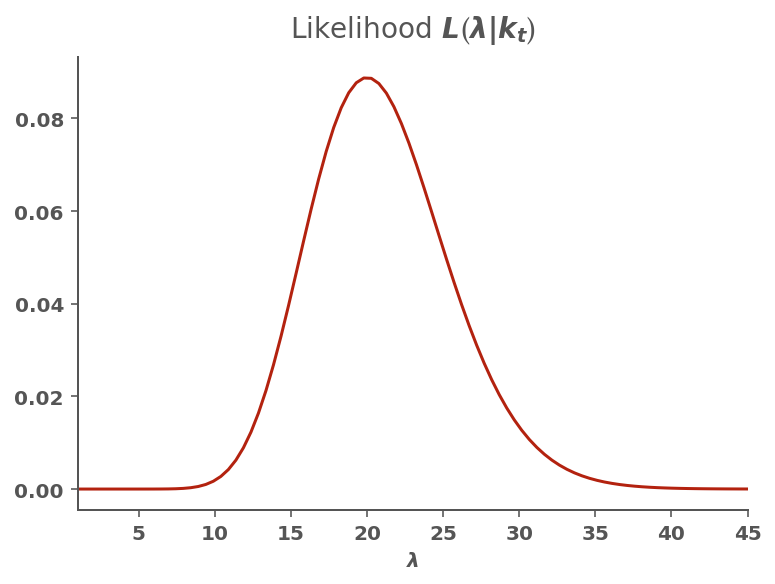

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $\mathcal{L}\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $\mathcal{L}\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 4 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

gamma = 1/serial = 1/7 = 0.142857142857


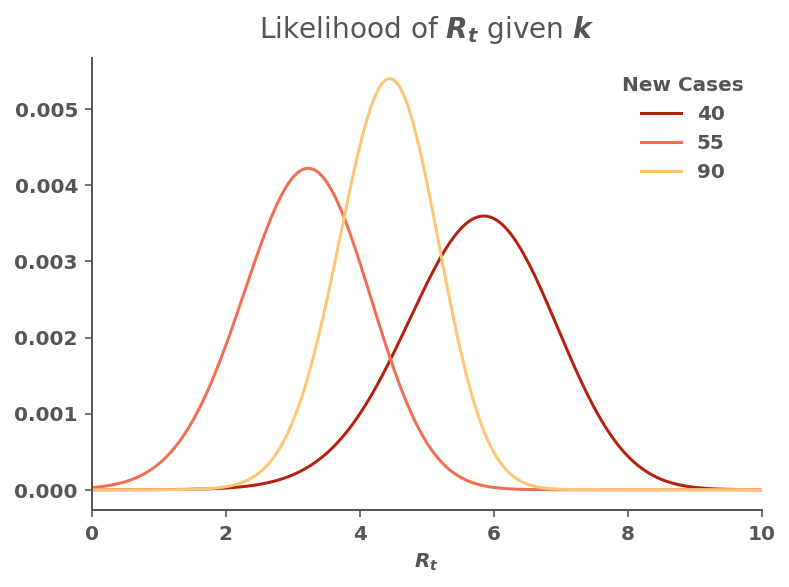

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = float(1)/7
print('gamma = 1/serial = 1/7 = %s' % GAMMA)

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:

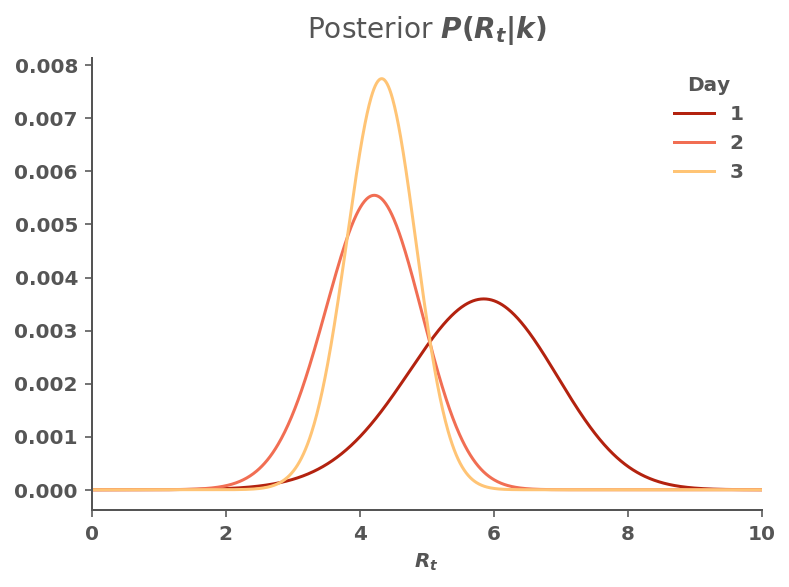

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

> Note: I apologize in advance for the clunky brute force HDI algorithm. Please let me know if there are better ones out there.

In [8]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low_%02d'%(p*100,), 'High_%02d'%(p*100,)])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.99,7.65
2,3.03,5.40
3,3.49,5.19


Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

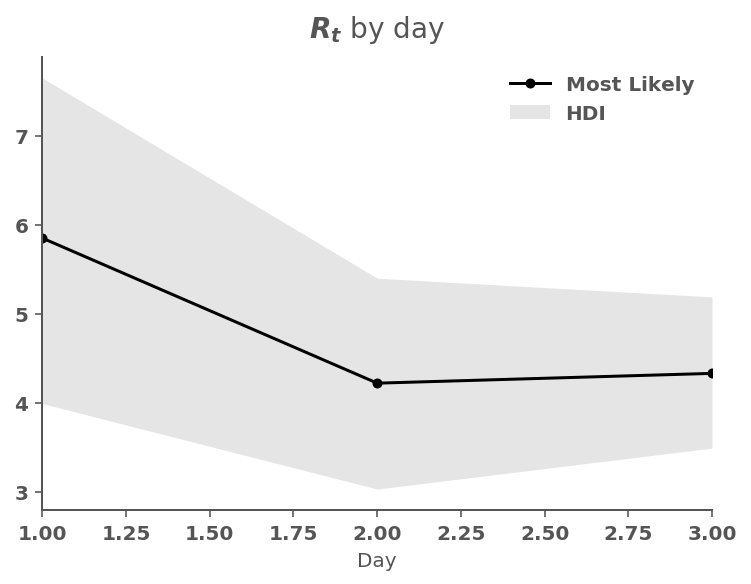

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title='$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the gaussian process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to US Data

### Setup

Load US state case data from the NYT archive

In [10]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [11]:
states.head(4)

state    date      
Alabama  2020-03-13     6
         2020-03-14    12
         2020-03-15    23
         2020-03-16    29
Name: cases, dtype: int64

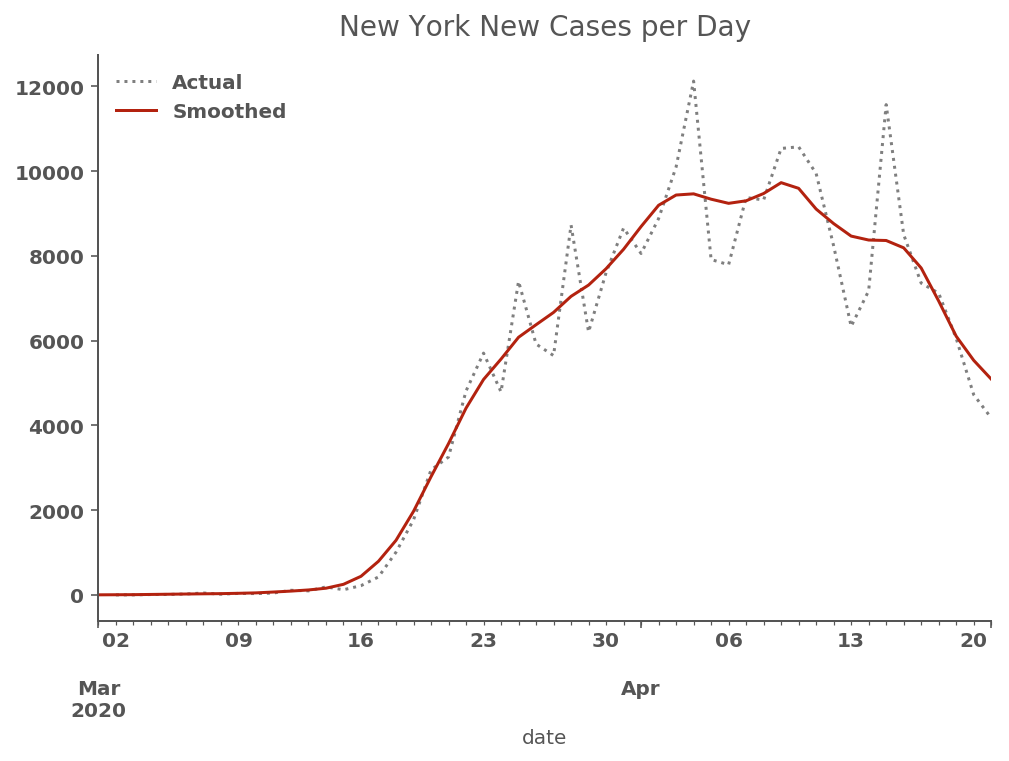

In [12]:
state_name = 'New York'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename("%s cases" % state_name)

original, smoothed = prepare_cases(cases)

original.plot(title="%s New Cases per Day" % state_name,
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

In [13]:
def get_posteriors(sr, process_sigma=0.15):

    # Create lambda based on the previous day's counts from all values of R_t
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # Evaluate Poisson on all days from 1 to end at all lambda values
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # Create a square process matrix that we use to 'blur' the previous day's
    # posterior. This introduces the random walk component such that Rt can
    # change from day to day.
    process_matrix = sps.norm(loc=r_t_range,
                              scale=process_sigma
                             ).pdf(r_t_range[:, None]) 

    # Normalize all rows because we're sampling the pdf and making an approximation
    process_matrix /= process_matrix.sum(axis=0)

    
    # Define an Initial Prior - you can choose a uniform here instead if you wish
    # I chose gamma with 5 because we need a positive distribution with an average
    # around a value that seems reasonable from a variety of studies.
    # https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
    prior0 = sps.gamma(a=5).pdf(r_t_range)
    prior0 /= prior0.sum()

    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )

    # Calculate posterior by multiplying likelihood by prior. The prior
    # is yesterday's posterior with the gaussian noise added via process_matrix
    for old_date, new_date in zip(sr.index[:-1], sr.index[1:]):
        new_prior = np.dot(process_matrix,posteriors[old_date])
        # new_prior = process_matrix @ posteriors[old_date] # python3 we miss you <3
        posteriors[new_date] = likelihoods[new_date] * new_prior
    
    p_data = posteriors.iloc[-1].sum()

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors, p_data

posteriors, p_data = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

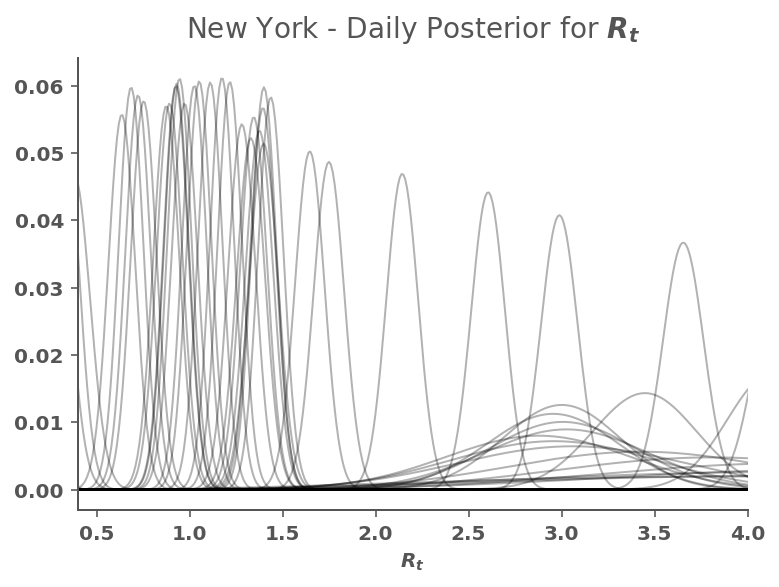

In [14]:
ax = posteriors.plot(title='%s - Daily Posterior for $R_t$' % state_name,
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [15]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-17,0.64,0.52,0.76
2020-04-18,0.33,0.21,0.46
2020-04-19,0.16,0.04,0.29
2020-04-20,0.28,0.15,0.43
2020-04-21,0.38,0.25,0.54


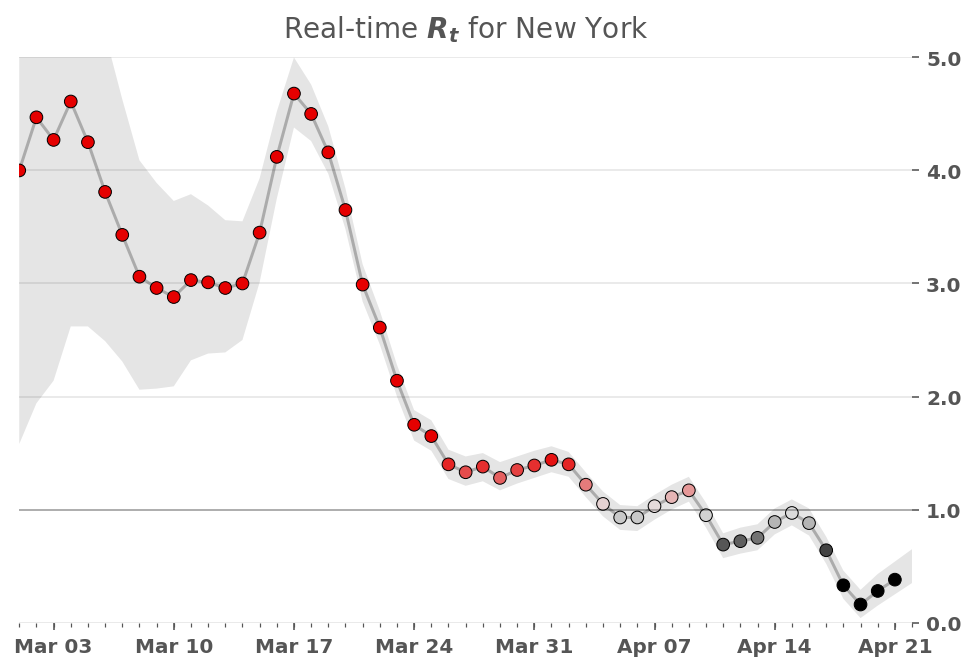

In [16]:
def plot_rt(result, ax, title):
    
    ax.set_title(title) #
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_title ='Real-time $R_t$ for %s' % state_name
plot_rt(result, ax, plot_title)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every State

In [17]:
states_results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

grouped_states_to_process = states_to_process.groupby(level='state')
for i, (state_name, cases) in enumerate(grouped_states_to_process):
    clear_output(wait=True)
    print('%s/%s Processing %s' % (str(i+1), len(grouped_states_to_process), state_name))
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors, p_data = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50, cases], axis=1)
    states_results[state_name] = result.droplevel(0)
    
# clear_output(wait=True)
print('Done.')

51/51 Processing Wyoming
	Getting Posteriors
	Getting HDIs
	Getting most likely values
Done.


### Plot All US States

/home/alex/.local/lib/python2.7/site-packages/matplotlib/colors.py:507: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


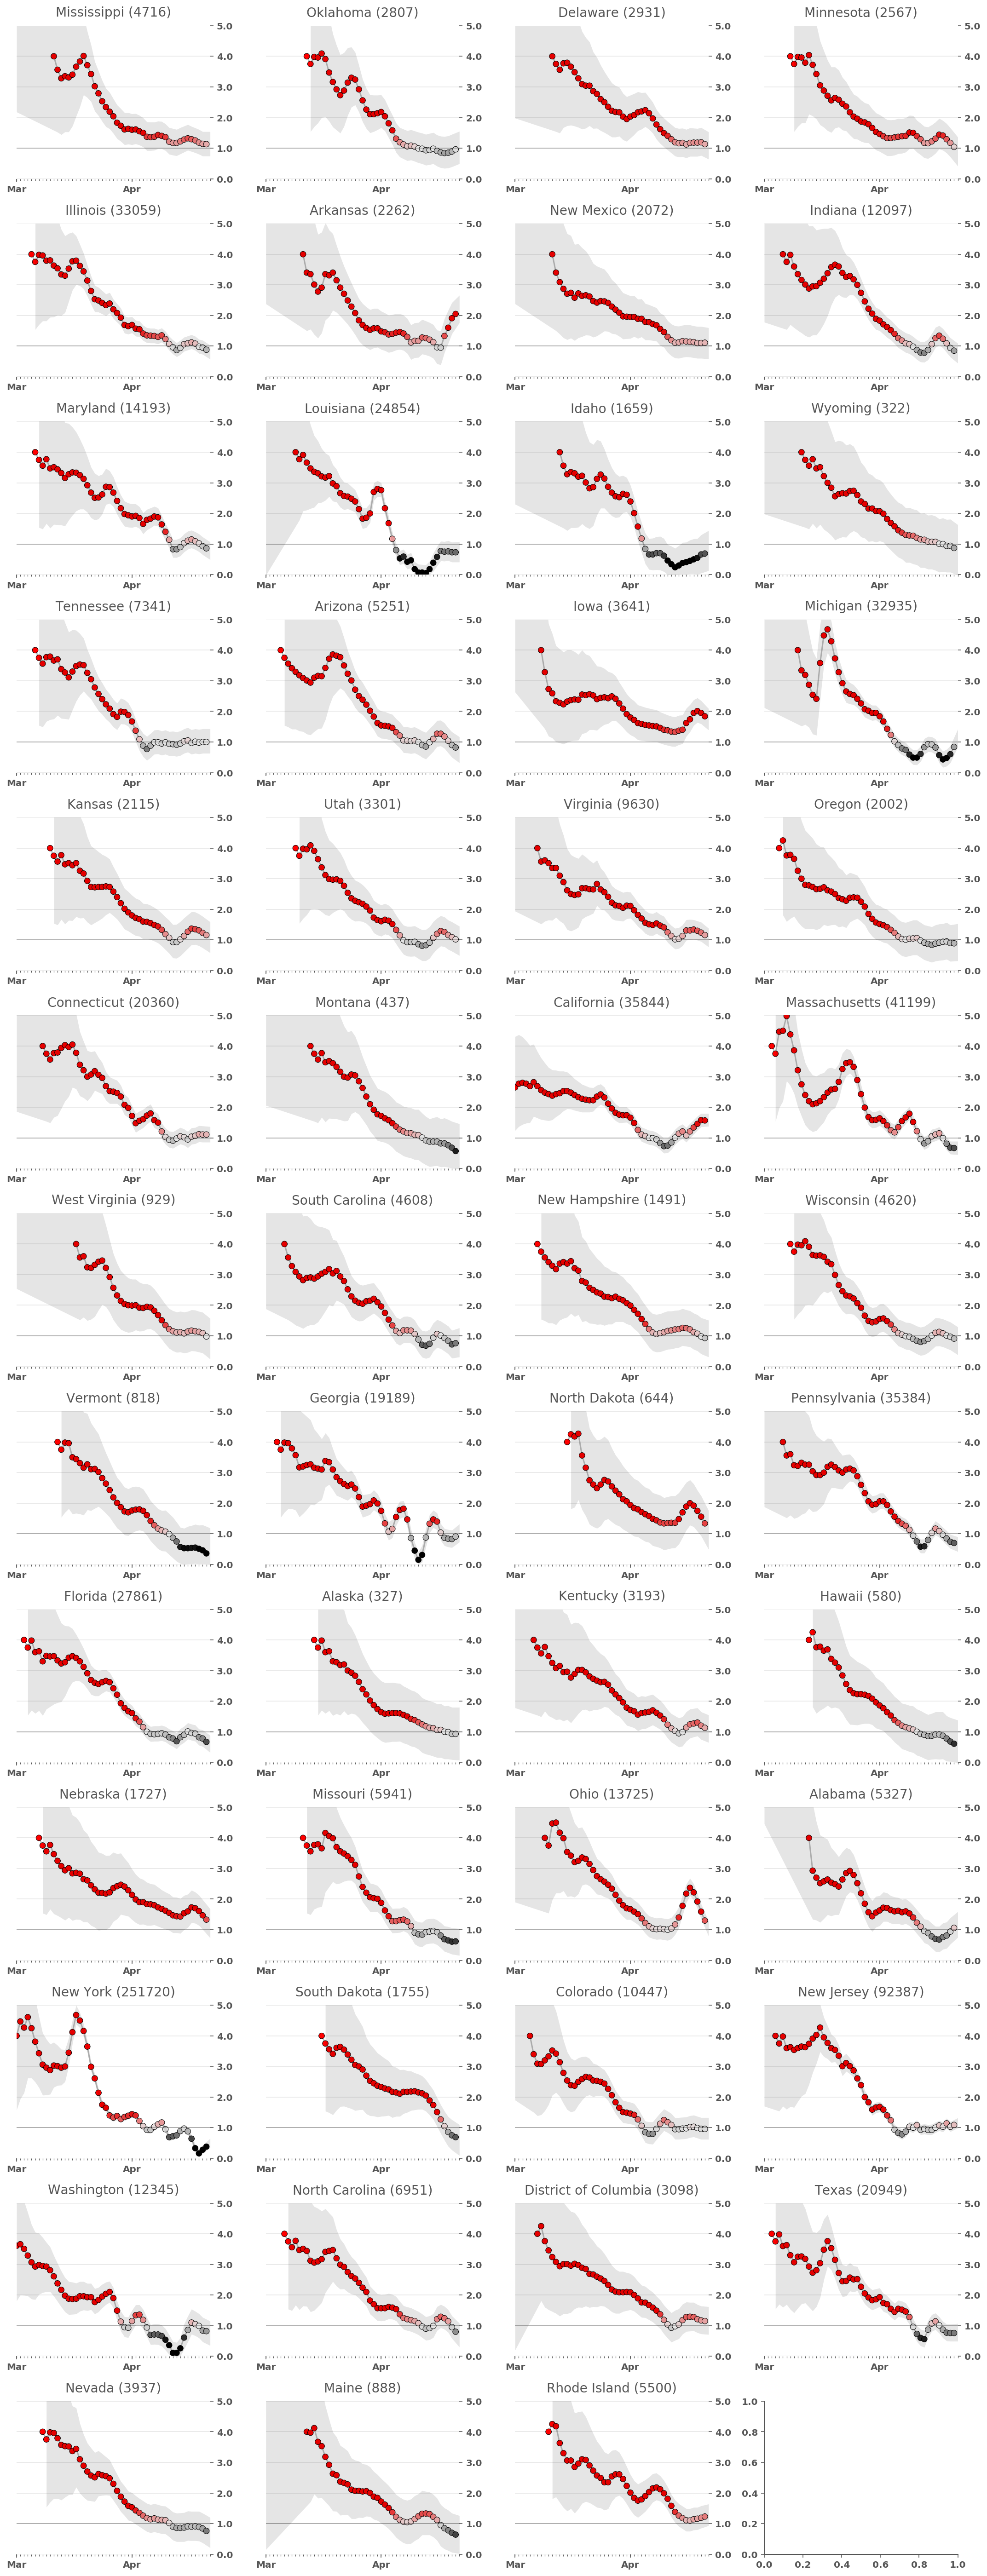

In [18]:
ncols = 4
nrows = int(np.ceil(len(states_results) / ncols)) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(states_results.items()):
    cumulative_cases = result.iloc[-1]['cases']
    plot_title = '%s (%s)' % (state_name, str(int(cumulative_cases)))
    plot_rt(result, axes.flat[i], plot_title)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [19]:
states_overall_rt_fname = './data/states_rt.csv'

In [20]:
states_overall = None

for state_name, result in states_results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index], names=['state', 'date'])
    if states_overall is None:
        states_overall = r
    else:
        states_overall = pd.concat([states_overall, r])

states_overall.sort_index(inplace=True)

print('saving states Rt data to %s' % states_overall_rt_fname)
states_overall.to_csv(states_overall_rt_fname)

saving states Rt data to ./data/states_rt.csv


### Read Data from CSV

(For returning to script)

In [40]:
states_overall = pd.read_csv(states_overall_rt_fname, index_col='state')
states_overall.head()

,date,ML,Low_90,High_90,Low_50,High_50,cases
state,,,,,,,
Alabama,2020-03-13,4.00,1.58,8.29,2.83,5.57,6
Alabama,2020-03-14,2.93,1.34,5.13,2.27,3.86,12
Alabama,2020-03-15,2.70,1.31,4.52,2.09,3.43,23
Alabama,2020-03-16,2.52,1.24,4.09,2.01,3.20,29
Alabama,2020-03-17,2.58,1.36,4.02,2.12,3.23,39


### Standings

In [22]:
# As of 4/12
no_lockdown = [
    'North Dakota',
    'South Dakota',
    'Nebraska',
    'Iowa',
    'Arkansas'
]
partial_lockdown = [
    'Utah',
    'Wyoming',
    'Oklahoma'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

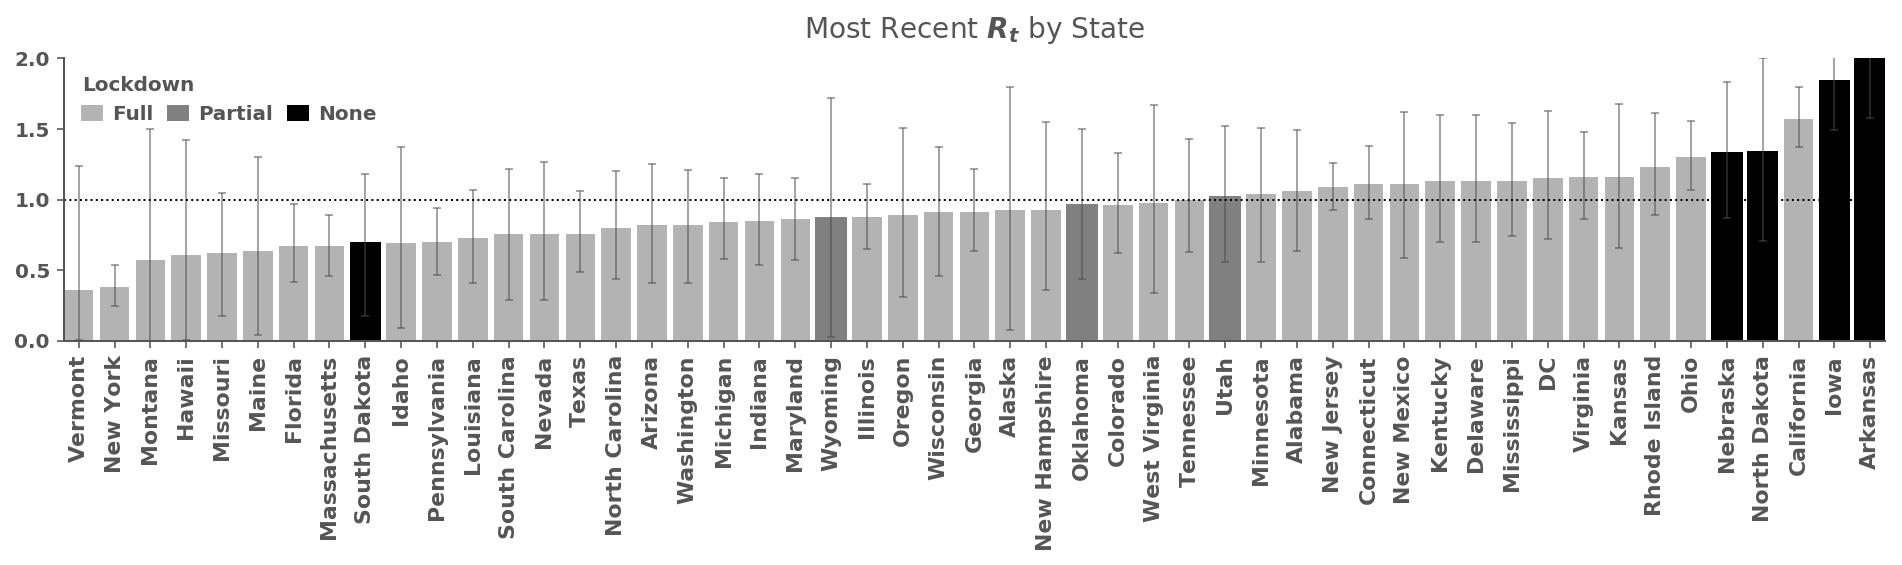

In [42]:
filtered = states_overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = states_overall.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)

plot_standings(mr);

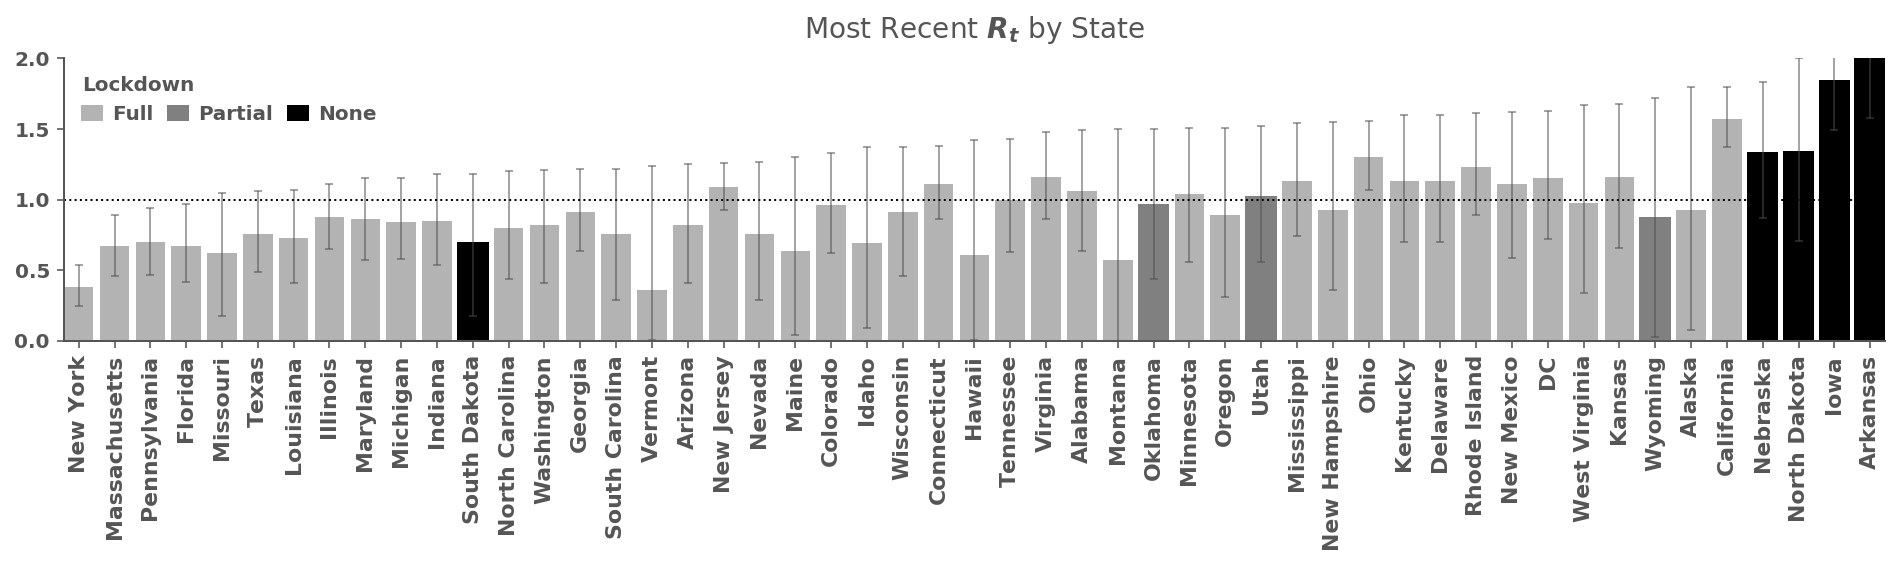

In [43]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

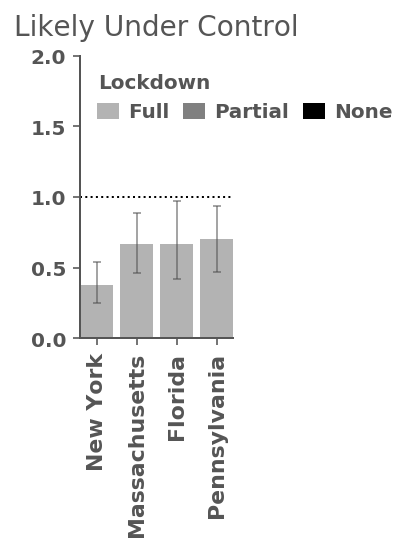

In [44]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

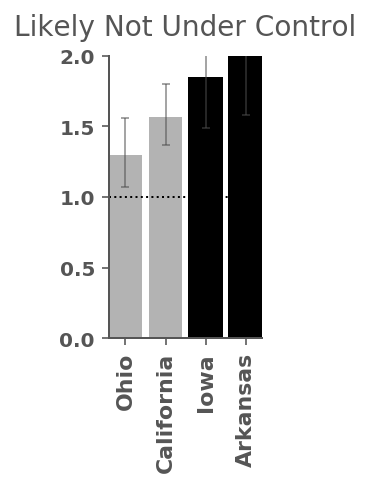

In [45]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()

# Counties

That was a nice introduction! Thanks! Now let's try this with counties data.

In particular, counties in the NY Metro area.


Moving forward to later compare to contacts data, use this notebook as reference: https://github.com/michielbakker/social-distance/blob/master/notebooks/contacts_vs_reported_cases_by_county.ipynb

In [46]:
STATE_COUNTY_ID = 'state_county_id'

NEW_YORK_CITY = 'New York City'

In [48]:
counties_cases_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

all_counties_cases_df = pd.read_csv(counties_cases_data_url,
                     usecols=[0,1,2,3,4], # drop deaths. Too morbid. Can't handle. And maybe not informative enough?
                    # index_col=['county', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

all_counties_cases_df.head(3)

,date,county,state,fips,cases
0,2020-01-21,Snohomish,Washington,53061.0,1
1,2020-01-22,Snohomish,Washington,53061.0,1
2,2020-01-23,Snohomish,Washington,53061.0,1


subset data to NY metro area

Get MSA / County FIPs code data. It's from: https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html

In [49]:
fips_filepath = './data/cbsa-msa-county-state-fips-2018.csv'

fips_df = pd.read_csv(fips_filepath, usecols=[3,9,10])
cbsa_fips = fips_df[fips_df['CBSA Title'] == 'New York-Newark-Jersey City, NY-NJ-PA']
# there are 23 counties in New York Metro area according to Wikipedia: https://en.wikipedia.org/wiki/New_York_metropolitan_area
assert(cbsa_fips.shape[0] == 23)

cbsa_fips.head(3)

,CBSA Title,FIPS State Code,FIPS County Code
1205,"New York-Newark-Jersey City, NY-NJ-PA",36.0,59.0
1206,"New York-Newark-Jersey City, NY-NJ-PA",36.0,103.0
1207,"New York-Newark-Jersey City, NY-NJ-PA",34.0,13.0


In [50]:
# get the counties fips
# STATE+COUNTY = 2+3=5
COUNTY_FIPS_CODE = 'full county fips code'
metro_area_county_fips = cbsa_fips['FIPS State Code'].apply(lambda x: str(int(x)).zfill(2)) + cbsa_fips['FIPS County Code'].apply(lambda x: str(int(x)).zfill(3))
metro_area_county_fips = metro_area_county_fips.astype('float64')

Just keep  the  counties  data for NY metro area

New York City counties (New York, Kings, Queens, Bronx and Richmond) were combined.

In [51]:
# Just keep  the  counties  data for NY metro area
ny_counties_cases_df = all_counties_cases_df[\
    (all_counties_cases_df['fips'].isin(metro_area_county_fips)) \
     | (all_counties_cases_df['county']=='New York City')]

# index by county,  date
ny_counties_cases_df = ny_counties_cases_df.sort_values('county').set_index(['county','date']).sort_index()
ny_counties_cases_df.head()

state     fips  cases
county date                                  
Bergen 2020-03-04  New Jersey  34003.0      1
       2020-03-05  New Jersey  34003.0      2
       2020-03-06  New Jersey  34003.0      3
       2020-03-07  New Jersey  34003.0      3
       2020-03-08  New Jersey  34003.0      4

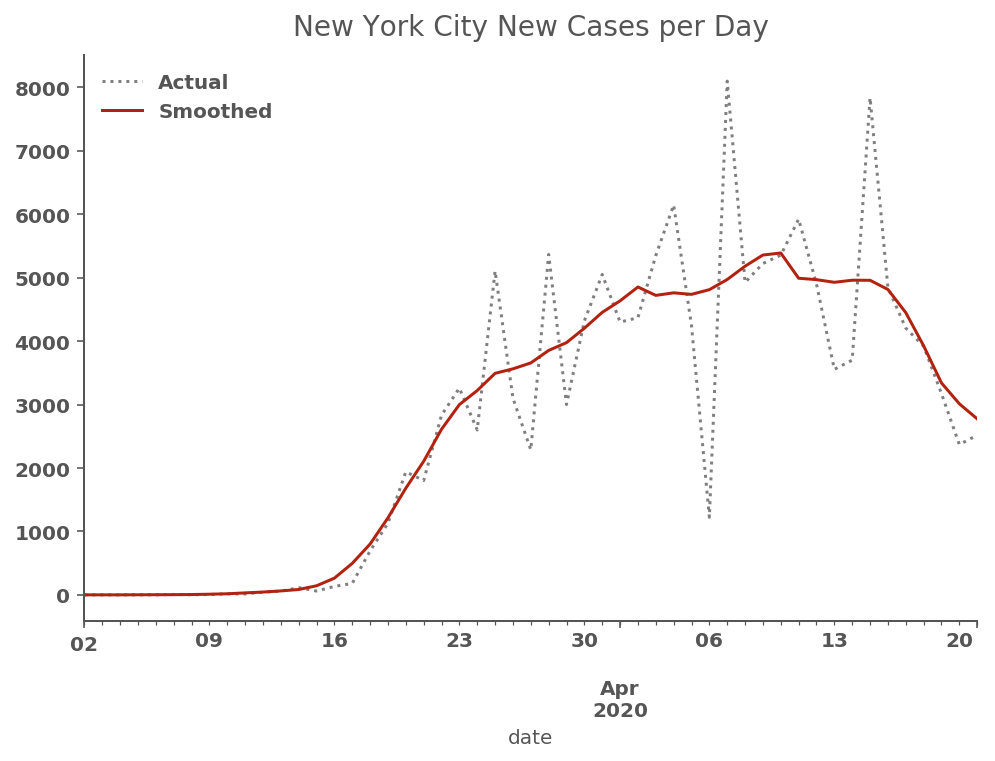

In [52]:
name = 'New York City'

cases = ny_counties_cases_df.xs(name)['cases']


original, smoothed = prepare_cases(cases)

original.plot(title="%s New Cases per Day" % name,
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Plot RT

In [53]:
name = 'New York City'
cases = ny_counties_cases_df.xs(name)['cases']
original, smoothed = prepare_cases(cases)

posteriors, p_data = get_posteriors(smoothed)
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis, cases], axis=1)
result.tail()

,ML,Low_90,High_90,cases
date,,,,
2020-04-17,0.55,0.41,0.71,127352
2020-04-18,0.25,0.10,0.41,131273
2020-04-19,0.00,0.00,0.23,134446
2020-04-20,0.19,0.05,0.37,136816
2020-04-21,0.34,0.17,0.53,139335


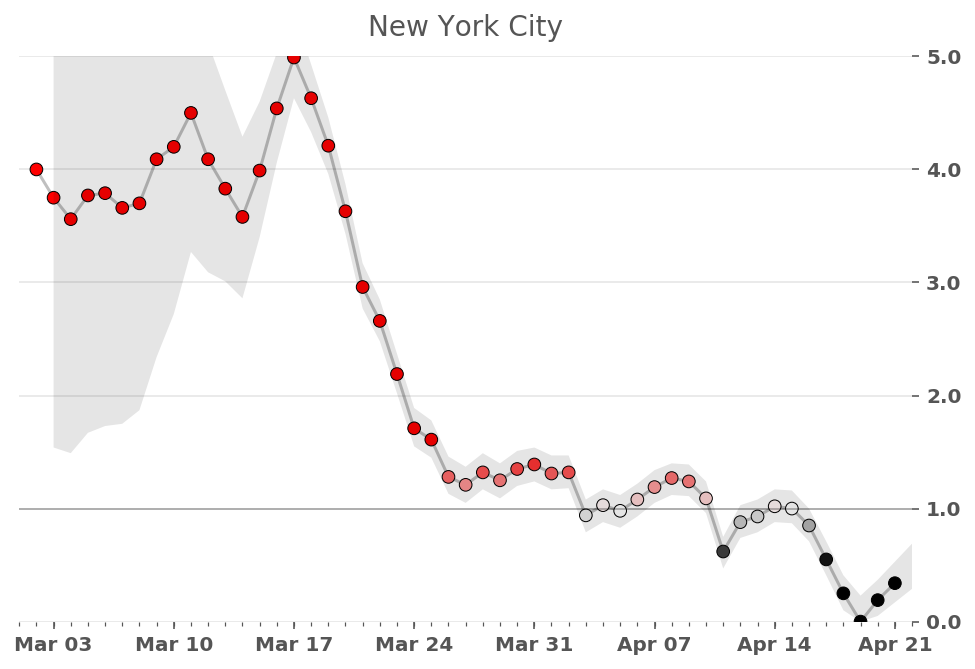

In [54]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, name)
# ax.set_title('Real-time $R_t$ for %s' % name)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the process for every county

In [55]:
county_results = {}

counties_to_process = ny_counties_cases_df
grouped_counties_to_process = counties_to_process.groupby(level='county')

for i, (name, cases) in enumerate(grouped_counties_to_process):
    clear_output(wait=True)
    print('%s/%s Processing %s' % (str(i+1), len(grouped_counties_to_process), name))
    new, smoothed = prepare_cases(cases['cases'])
    print('\tGetting Posteriors')
    try:
        posteriors, p_data = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50, cases], axis=1)
    county_results[name] = result.droplevel(0)
    
# clear_output(wait=True)
print('Done.')

19/19 Processing Westchester
	Getting Posteriors
	Getting HDIs
	Getting most likely values
Done.


### Plot All NY metro area counties

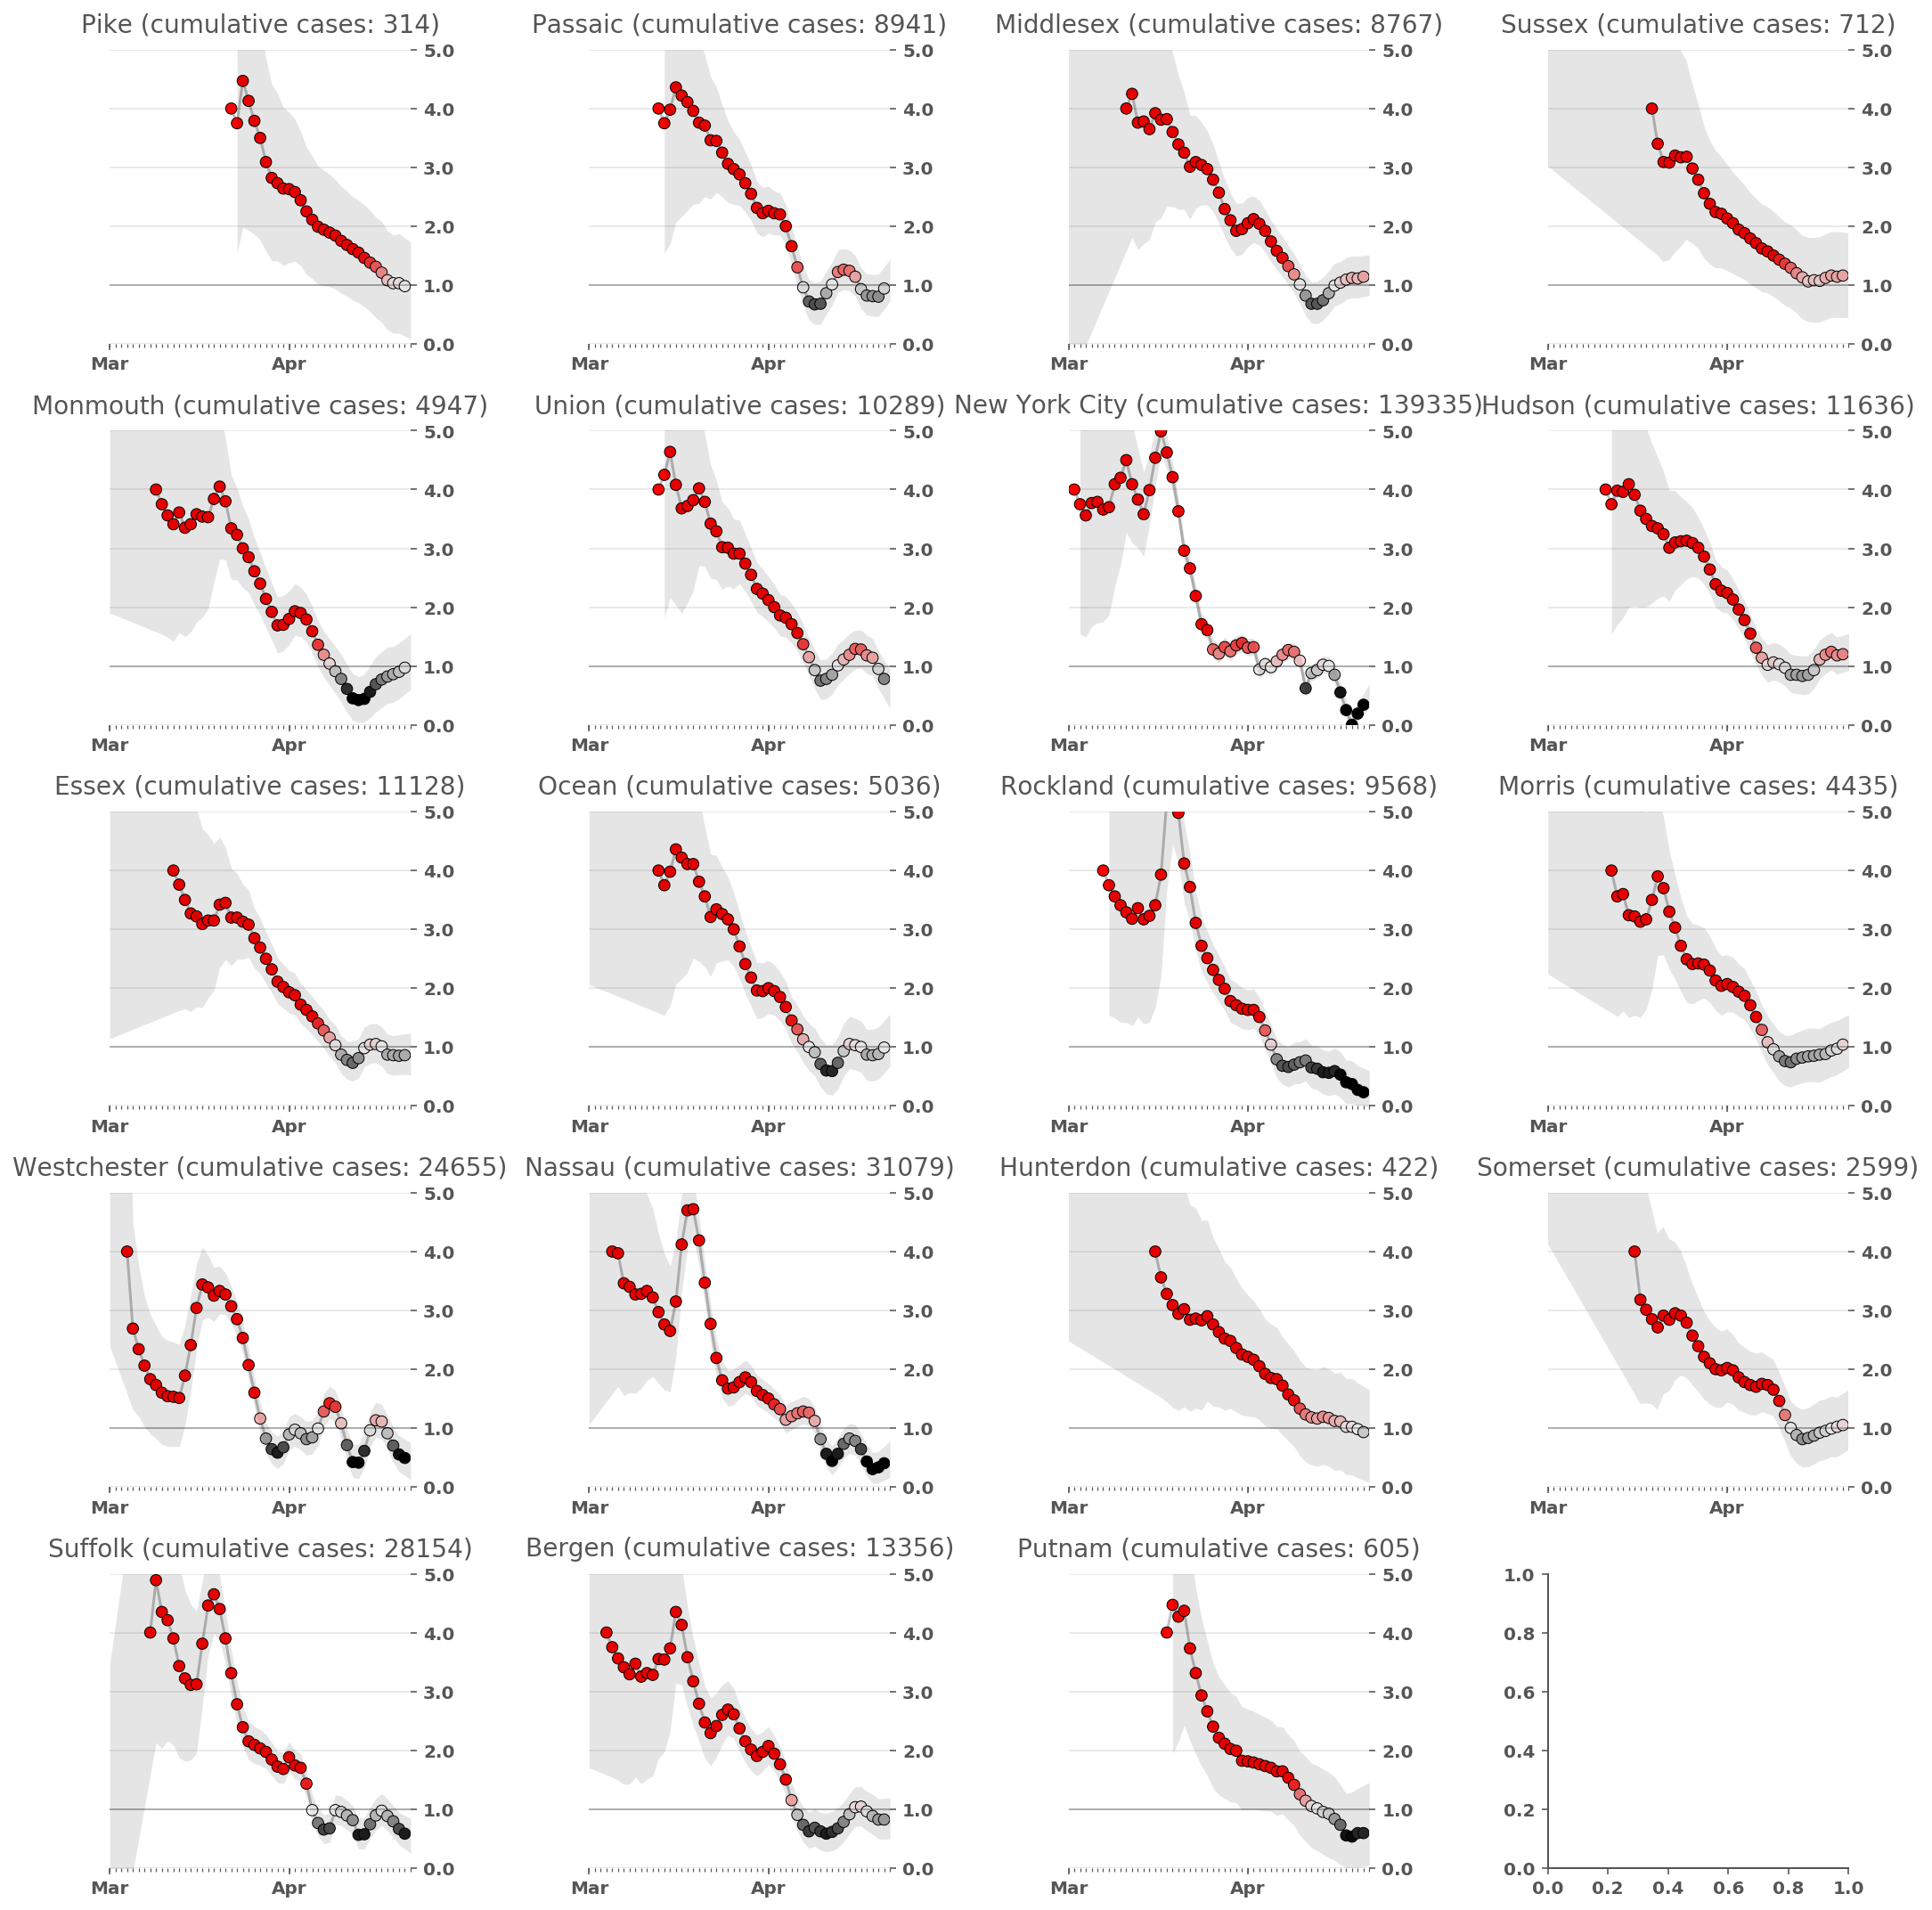

In [57]:
ncols = 4
nrows = int(np.ceil(len(county_results) / ncols)) + 1

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (name, result) in enumerate(county_results.items()):
    cumulative_cases = result.iloc[-1]['cases']
    plot_title = '%s (cumulative cases: %s)' % (name, str(cumulative_cases))
    plot_rt(result, axes.flat[i], plot_title)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV


In [58]:
ny_counties_rts_fname = './data/ny_counties_rt.csv'

In [59]:
ny_counties_rts = None

for name, result in county_results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[name], result.index], names=['county', 'date'])
    if ny_counties_rts is None:
        ny_counties_rts = r
    else:
        ny_counties_rts = pd.concat([ny_counties_rts, r])

ny_counties_rts.sort_index(inplace=True)

# Uncomment this line if you'd like to export
print('saving NY counties Rt data to %s' % ny_counties_rts_fname)
ny_counties_rts.to_csv(ny_counties_rts_fname)
ny_counties_rts.head()

saving NY counties Rt data to ./data/ny_counties_rt.csv


ML  Low_90  High_90  Low_50  High_50       state  \
county date                                                             
Bergen 2020-03-04  4.00    1.58     8.29    2.83     5.57  New Jersey   
       2020-03-05  3.75    1.54     7.31    2.80     5.19  New Jersey   
       2020-03-06  3.56    1.49     6.71    2.65     4.82  New Jersey   
       2020-03-07  3.41    1.42     6.27    2.53     4.55  New Jersey   
       2020-03-08  3.29    1.42     6.01    2.45     4.36  New Jersey   

                      fips  cases  
county date                        
Bergen 2020-03-04  34003.0      1  
       2020-03-05  34003.0      2  
       2020-03-06  34003.0      3  
       2020-03-07  34003.0      3  
       2020-03-08  34003.0      4

### Read data from CSV

(Re-entry for notebook)

In [60]:
ny_counties_rts = pd.read_csv(ny_counties_rts_fname,
                     index_col=['county', 'date'],
                     parse_dates=['date']).sort_index()
ny_counties_rts.head()

ML  Low_90  High_90  Low_50  High_50       state  \
county date                                                             
Bergen 2020-03-04  4.00    1.58     8.29    2.83     5.57  New Jersey   
       2020-03-05  3.75    1.54     7.31    2.80     5.19  New Jersey   
       2020-03-06  3.56    1.49     6.71    2.65     4.82  New Jersey   
       2020-03-07  3.41    1.42     6.27    2.53     4.55  New Jersey   
       2020-03-08  3.29    1.42     6.01    2.45     4.36  New Jersey   

                      fips  cases  
county date                        
Bergen 2020-03-04  34003.0      1  
       2020-03-05  34003.0      2  
       2020-03-06  34003.0      3  
       2020-03-07  34003.0      3  
       2020-03-08  34003.0      4

### Smell check!

Check: Is data availability too much of a problem for this Rt algorithm at this point in reporting  history?

Is the number of cumulative cases closely correlated with Rt?


In [61]:
ny_counties_mr = ny_counties_rts.groupby(level=0)[['ML', 'High_90', 'Low_90', 'cases']].last()
ny_counties_mr.head(3)

,ML,High_90,Low_90,cases
county,,,,
Bergen,0.82,1.18,0.49,13356
Essex,0.86,1.22,0.53,11128
Hudson,1.20,1.52,0.89,11636


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42e243f810>)

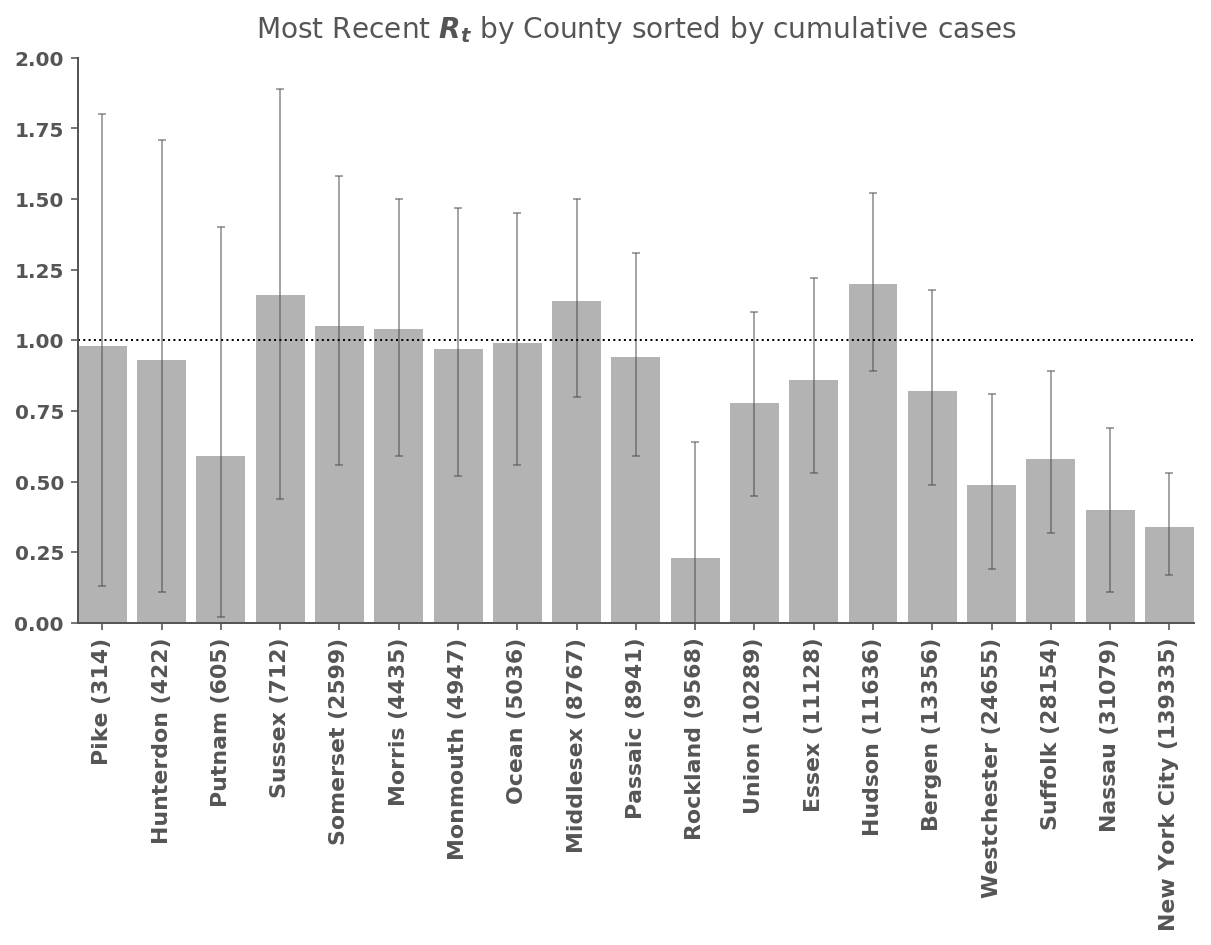

In [62]:
def plot_local_standings(mr, figsize=None, title='Most Recent $R_t$ by County'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = ny_counties_mr.reset_index().apply(lambda row: '%s (%s)'%(str(row['county']),str(row['cases'])), axis=1)# + '(%s)'%row[cases])

    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

ny_counties_mr.sort_values('cases', inplace=True)

plot_local_standings(ny_counties_mr,
                     figsize=(10,5),
                     title='Most Recent $R_t$ by County sorted by cumulative cases')


Now look into how many points of contact occur in these counties....

